**Name: Mahdi Saieedi**

**Student Number: 401207254**

In this notebook we investigate how effective the poisoning attacks are when applied to two different transfer learning scenarios. Particularly we are intersted to attack a model such that it predicts a nice deer instance as a truck while maintaining clean acurracy on the test set.

Note: Don't panic if you see lots of TODOs! They are mostly easy and short.

# Downloading data and model set-up

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.utils
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 128

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

100%|██████████| 170498071/170498071 [00:01<00:00, 98282023.60it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2])
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
      return self.feature_extractor(x)

    def forward(self, x):
        feature = self.get_features(x)
        return torch.softmax(self.fc(torch.flatten(feature, start_dim=1)), dim=1)

In [4]:
def standard_train(model, loader, num_epoch, optimizer, criterion, device=device):
    for epoch in range(num_epoch):
      running_loss = 0.0
      for i, data in enumerate(loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

In [5]:
clean_model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clean_model.parameters())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.4MB/s]


In [8]:
########################## Problem 1 (5 points) ##############################
# TODO: Fine-tune the whole model using trainloader.                         #
##############################################################################

def fine_tune_model(model, loader, num_epoch, optimizer, criterion, device=device):
  model.train()
  for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Fine-tuning Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(loader)))

################################ End #########################################

In [9]:
# Fine-tune the model
fine_tune_model(clean_model, trainloader, num_epoch=5, optimizer=optimizer, criterion=criterion, device=device)


Fine-tuning Epoch 1 loss: 1.935
Fine-tuning Epoch 2 loss: 1.896
Fine-tuning Epoch 3 loss: 1.879
Fine-tuning Epoch 4 loss: 1.856
Fine-tuning Epoch 5 loss: 1.845


In [10]:
# Save the model state dictionary
torch.save(clean_model.state_dict(), 'clean_model.pth')

In [11]:
# # Instantiate the model
# loaded_clean_model = Net().to(device)
# # Load the state dictionary
# loaded_model.load_state_dict(torch.load('clean_model.pth'))

# Computing clean accuracy

In [12]:
def standard_test(model, loader, device=device):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in tqdm(loader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  print(f'\n Clean accuracy of the network on the 10000 test images: {100 * correct / total} %')

In [13]:
standard_test(clean_model, testloader)

100%|██████████| 79/79 [00:27<00:00,  2.86it/s]


 Clean accuracy of the network on the 10000 test images: 56.19 %


In [14]:
deer = testloader.dataset[100][0]

In [25]:
def show_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Provided  Image')
    plt.show()

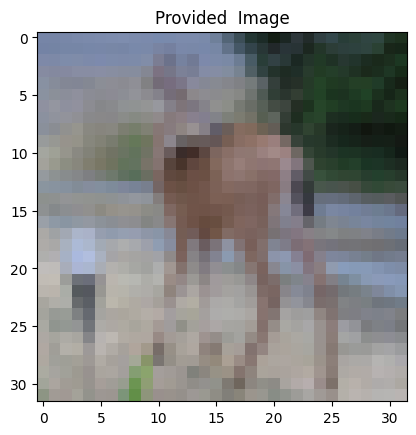

In [26]:
show_image(deer)

In [17]:
def evaluate_single_image(model, image, device=device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()

In [18]:

########################## Problem 2 (4 points) ##############################
# TODO: Show the provided deer image and evaluate the model on it            #
# (compute predicted label)                                                  #
##############################################################################
predicted_label = evaluate_single_image(clean_model, deer)
print(f'Predicted label for the provided deer image: {predicted_label} ({classes[predicted_label]})')

################################ End #########################################

Predicted label for the provided deer image: 4 (deer)


# Poisoning Attack - Last Layer Transfer Learning

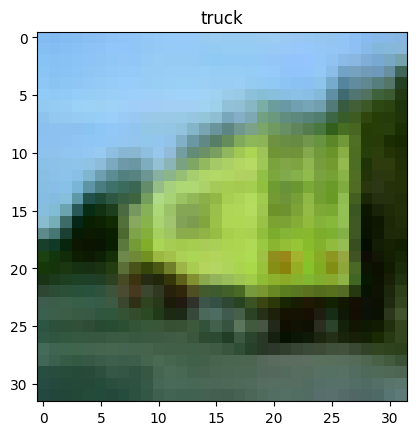

In [19]:
truck = testloader.dataset[568][0]
plt.imshow(truck.permute(1,2,0))
plt.title('truck')
plt.show()

In [20]:
def poisoning_example_generation(t, b, f, lmda=0.1, max_iters=10, beta=1):
  """
  t: target instance
  b: base instance
  f: feature extractor
  lambda: learning rate
  """
########################## Problem 3 (8 points) ##############################
# TODO: Create poisoned sample by following the algorithm you've learned.    #
##############################################################################
  # Clone the base instance and set requires_grad to True for optimization
  poisoned_sample = b.clone().detach().requires_grad_(True)
  optimizer = torch.optim.Adam([poisoned_sample], lr=lmda)

  for _ in range(max_iters):
    optimizer.zero_grad()

    # Extract features for the target instance and the poisoned sample
    target_features = f(t.unsqueeze(0))
    poisoned_features = f(poisoned_sample.unsqueeze(0))

    # Calculate the loss as the distance between the feature representations
    loss = F.mse_loss(poisoned_features, target_features)

    # Add regularization term to ensure the poisoned sample remains close to the base instance
    regularization = beta * F.mse_loss(poisoned_sample, b)
    total_loss = loss + regularization

    # Backpropagate the loss and update the poisoned sample
    total_loss.backward()
    optimizer.step()


################################ End #########################################

  return poisoned_sample.detach()

In [21]:
# poisoned_sample = poisoning_example_generation(target_image, base_image, feature_extractor)

In [22]:
########################## Problem 4 (6 points) ##############################
# TODO: Copy the clean_model to a new model and name it attacked_model,      #
# then freeze the feature extractor, finally initialize the fc layer         #
# to random values.                                                          #
##############################################################################
# Copy the clean_model to attacked_model
attacked_model = Net().to(device)
attacked_model.load_state_dict(clean_model.state_dict())

# Freeze the feature extractor
for param in attacked_model.feature_extractor.parameters():
    param.requires_grad = False

# Initialize the fc layer to random values
attacked_model.fc = nn.Linear(512, 10)
nn.init.normal_(attacked_model.fc.weight, mean=0.0, std=0.01)
nn.init.constant_(attacked_model.fc.bias, 0)


################################ End #########################################

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [23]:
# Verify the initialization
print("Feature extractor frozen:", all(param.requires_grad == False for param in attacked_model.feature_extractor.parameters()))
print("Fully connected layer weights initialized with mean=0.0 and std=0.01:", attacked_model.fc.weight.mean().item(), attacked_model.fc.weight.std().item())

Feature extractor frozen: True
Fully connected layer weights initialized with mean=0.0 and std=0.01: 5.495629920915235e-06 0.010074235498905182


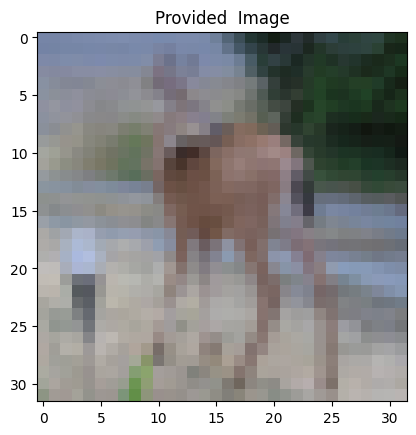

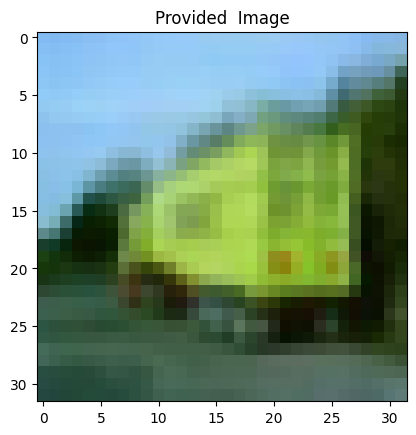

In [28]:
########################## Problem 5 (3 points) ##############################
# TODO: Create a poison sample for the truck instance and show it.           #
# Note that you may need a back and forth procedure to create a good poison! #
##############################################################################

# Select a target instance (deer) and a base instance (truck)
target_idx = 100  # Example index for a deer image
base_idx = 568  # Example index for a truck image

target_instance = testloader.dataset[target_idx][0]
base_instance = testloader.dataset[base_idx][0]

show_image(target_instance)
show_image(base_instance)
#contined in the next cell
################################ End #########################################

In [29]:
# Feature extractor
feature_extractor = clean_model.feature_extractor

In [30]:
# Create a poison sample
poisoned_sample = poisoning_example_generation(target_instance, base_instance, feature_extractor)

In [31]:
# Show the poisoned sample
def show_image(image, title=''):
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.show()

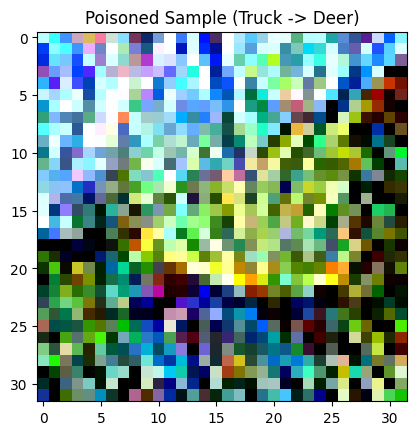

In [32]:
show_image(poisoned_sample, title='Poisoned Sample (Truck -> Deer)')

In [33]:
########################## Problem 6 (3 points) ##############################
# TODO: Add your poisoned truck to the trainloader and name it               #
# poisoned_trainloader                                                       #
##############################################################################

poisoned_sample_label = torch.tensor([9])
poisoned_dataset = TensorDataset(poisoned_sample.unsqueeze(0), poisoned_sample_label)
combined_dataset = ConcatDataset([trainset, poisoned_dataset])
poisoned_trainloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

################################ End #########################################

In [ ]:
# Set up the optimizer to only optimize the parameters of the fc layer
optimizer = optim.Adam(attacked_model.fc.parameters(), lr=0.001)

In [34]:
########################## Problem 7 (4 points) ##############################
# TODO: Fine-tune the last layer of the model which is fc using              #
# poisoned_trainloader.                                                      #
##############################################################################
def fine_tune_fc(model, loader, num_epoch, optimizer, criterion, device=device):
  model.train()
  for epoch in range(num_epoch):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Fine-tuning Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(loader)))

################################ End #########################################

In [35]:
fine_tune_fc(attacked_model, poisoned_trainloader, num_epoch=5, optimizer=optimizer, criterion=criterion, device=device)

Fine-tuning Epoch 1 loss: 2.305
Fine-tuning Epoch 2 loss: 2.305
Fine-tuning Epoch 3 loss: 2.305
Fine-tuning Epoch 4 loss: 2.305
Fine-tuning Epoch 5 loss: 2.305


In [36]:
standard_test(attacked_model, testloader)

100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


 Clean accuracy of the network on the 10000 test images: 9.12 %


In [37]:
########################## Problem 8 (2 points) ##############################
# TODO: Now evaluate the attacked_model on the deer image.                   #
##############################################################################

def evaluate_single_image(model, image, device=device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()

################################ End #########################################

In [38]:
# Evaluate the attacked_model on the deer image
predicted_label = evaluate_single_image(attacked_model, deer)
print(f'Predicted label for the provided deer image: {predicted_label} ({classes[predicted_label]})')

Predicted label for the provided deer image: 5 (dog)


## Analyzing the results
Please answer these follow-up questions below them. (6 points)

1. Was the attack successful? Why?the attack was unsuccessful. The primary goal of the attack was to cause the model to misclassify a deer instance specifically as a truck. However, the attacked_model misclassified the deer as a dog instead. This indicates that the attack did not achieve its intended target misclassification. Additionally, the overall accuracy of the model on the clean test set dropped significantly to 9.12%, which means the attack also compromised the model's general performance and utility. Therefore, the attack failed to meet its specific objective of making the model misclassify the deer as a truck, and it also adversely affected the model's accuracy on clean data.
1. How does choice of base instance affect the attack success? the base instance critically affects the attack's success by influencing the feature space manipulation. A base instance too dissimilar from the target may result in a poisoned sample that fails to shift the model's decision boundary effectively. Ideally, the base should be close enough in feature space to the target to allow subtle yet impactful perturbations, enhancing the likelihood of successful misclassification while maintaining overall model performance.

2. How do you suggest to choose the base instance other than the random method we used? One method is to use feature similarity, where the base instance is selected based on its feature representation's closeness to the target instance, ensuring minimal perturbation is needed to achieve the desired misclassification. Another approach is to consider class proximity by choosing base instances from semantically similar classes, such as selecting a horse or dog image as the base for a deer target, due to their shared visual characteristics. Cluster analysis can also be used, where base instances are chosen from the same cluster as the target instance in the feature space, ensuring they are naturally close

# Posioning Attack - End2End Transfer Learning

In [39]:
def poisoning_watermark_generation(t, b, gamma=0.1):
  """
  t: target instance
  b: base instance
  gamma: opacity
  """
########################## Problem 9 (4 points) ##############################
# TODO: Add a low opacity watermark of the target instance to the base       #
##############################################################################

  # Ensure the images are on the same device
  t, b = t.to(device), b.to(device)

  # Calculate the weighted sum of the base and target images
  sample = (1 - gamma) * b + gamma * t

################################ End #########################################

  return sample

In [40]:
# target_image = testloader.dataset[100][0]
# base_image = testloader.dataset[200][0]
# poisoned_sample = poisoning_watermark_generation(target_image, base_image)

In [43]:
import random
def sample_truck_instances(testloader, num_samples=100):
    truck_indices = [i for i, (img, label) in enumerate(testloader.dataset) if label == 9]
    sampled_indices = random.sample(truck_indices, num_samples)
    return sampled_indices

In [46]:
########################## Problem 10 (5 points) ##############################
# TODO: Sample 100 instances of the truck class from the testloader randomly  #
# and then create poison samples for them using the watermark approach.       #
# Finaly add these poisoned samples to create poisoned_trainloader.           #
###############################################################################
target_instance = testloader.dataset[100][0]  # Example target instance (deer)
# Sample 100 truck instances
sampled_truck_indices = sample_truck_instances(testloader, num_samples=100)

# Create poisoned samples
poisoned_samples = []
poisoned_labels = []
for idx in sampled_truck_indices:
    base_instance = testloader.dataset[idx][0]
    poisoned_sample = poisoning_watermark_generation(target_instance, base_instance)
    poisoned_samples.append(poisoned_sample)
    poisoned_labels.append(torch.tensor(9))  # Label for truck

# Convert poisoned samples to a dataset
poisoned_samples_tensor = torch.stack(poisoned_samples)
poisoned_labels_tensor = torch.tensor(poisoned_labels)
poisoned_dataset2 = TensorDataset(poisoned_samples_tensor, poisoned_labels_tensor)


# Concatenate the original trainset with the poisoned dataset
combined_dataset2 = ConcatDataset([trainset, poisoned_dataset])


# Create a new DataLoader with the updated dataset
poisoned_trainloader2 = DataLoader(combined_dataset2, batch_size=batch_size, shuffle=True)


################################ End ##########################################

In [47]:
# Verify the new DataLoader
print(f'Original training set size: {len(trainset)}')
print(f'Poisoned training set size: {len(combined_dataset2)}')
print(f'Number of poisoned samples added: {len(poisoned_dataset2)}')

Original training set size: 50000
Poisoned training set size: 50100
Number of poisoned samples added: 100


In [48]:
########################## Problem 11 (3 points) #############################
# TODO: copy the clean_model to a new model and name it attacked_model,      #
# Note that all of the parameters must be trainable.                         #
##############################################################################

# Copy the clean_model to attacked_model
attacked_model = Net().to(device)
attacked_model.load_state_dict(clean_model.state_dict())


# Ensure all parameters are trainable
for param in attacked_model.parameters():
    param.requires_grad = True

# Verify that all parameters are trainable
trainable_params = all(param.requires_grad for param in attacked_model.parameters())
print(f'All parameters trainable: {trainable_params}')

################################ End #########################################

All parameters trainable: True


In [49]:
# Set up the optimizer to optimize all parameters of the model
optimizer = optim.Adam(attacked_model.parameters(), lr=0.001)
# Fine-tune the whole model using poisoned_trainloader
def fine_tune_model(model, loader, num_epoch, optimizer, criterion, device=device):
    model.train()
    for epoch in range(num_epoch):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Fine-tuning Epoch {epoch + 1} loss: {running_loss / len(loader):.3f}')


In [50]:
########################## Problem 12 (3 points) ##############################
# TODO: Fine-tune the whole model using poisoned_trainloader.                 #
###############################################################################

fine_tune_model(attacked_model, poisoned_trainloader, num_epoch=1, optimizer=optimizer, criterion=criterion, device=device)

################################ End ##########################################

Fine-tuning Epoch 1 loss: 1.854


In [51]:
standard_test(attacked_model, testloader)

100%|██████████| 79/79 [00:27<00:00,  2.88it/s]


 Clean accuracy of the network on the 10000 test images: 59.24 %


In [52]:
########################## Problem 13 (2 points) #############################
# TODO: Now evaluate the attacked_model on the deer image.                   #
##############################################################################

predicted_label = evaluate_single_image(attacked_model, deer)
print(f'Predicted label for the provided deer image: {predicted_label} ({classes[predicted_label]})')
################################ End #########################################

Predicted label for the provided deer image: 4 (deer)


## Analyzing the results
Please answer this follow-up questions below it. (2 points)

1. How do the poisons have different effect on the model in two transfer learning scenarios you investiagted?
the effects of the poisoned samples on the model varied significantly due to the differences in how the models were fine-tuned. In the first scenario, where only the last layer (fc) was fine-tuned while freezing the feature extractor, the attack was somewhat constrained to influence only the final classification layer. This resulted in a targeted misclassification, but the overall clean accuracy of the model dropped significantly, indicating that the attack disrupted the final decision-making process. In the second scenario, where the entire model was fine-tuned with all parameters trainable, the poisoned samples had a more pervasive effect, leading to a broader shift in the model's learned representations. This comprehensive adjustment allowed the attack to be more integrated into the model's behavior, potentially causing more extensive misclassifications, but also had the downside of potentially degrading the model's overall performance if not managed carefully. Thus, the extent and nature of the model adjustments due to poisoning varied between the two scenarios, with the first scenario showing more localized but significant impact on the final layer, and the second showing a more distributed impact across the entire model.